# EXERCISE 4

Data from a bivariate process are reported in `ESE8_ex4.csv`. 
Assume we know both the mean and the standard deviation of the quality characteristics $x_1$ and $x_2$:
- $\mu_1 = 10$; $\mu_2= 20$;
- $\sigma_1= 1$; $\sigma_2= 2$.

Assume we also know the correlation coefficient: $\rho_{12} = 0.8$.

Design a control chart for the mean of the process.

> ## Solution

In [1]:
# Import the necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd

# Import the data
data = pd.read_csv('ESE8_ex4.csv')

# Define the parameters
mu_1 = 10
mu_2 = 20

std_1 = 1
std_2 = 2

corr = 0.8

data.head()

,Sample,x1,x2
0,1,11.09,20.28
1,2,9.33,19.01
2,3,10.95,20.96
3,4,10.53,21.33
4,5,11.95,22.51


> From the correlation coefficient we can estimate the covariance. Thus, the mean vector and the variance/covariance matrix are:

In [2]:
# Create the mean vector
mu = pd.Series({'x1': mu_1, 'x2': mu_2})

# Calculate the variance/covariance matrix
covariance = corr * std_1 * std_2
var_1 = std_1**2
var_2 = std_2**2

# define the covariance matrix as a pandas dataframe
S = pd.DataFrame([[var_1, covariance],
                [covariance, var_2]],
                columns=['x1', 'x2'],
                index=['x1', 'x2'])

print("The mean vector is: \n", mu)
print("\nThe variance/covariance matrix is: \n", S)

The mean vector is: 
 x1    10
x2    20
dtype: int64

The variance/covariance matrix is: 
      x1   x2
x1  1.0  1.6
x2  1.6  4.0


> The quality characteristics are monitored by using individual measurements so $n=1$. We can implement a $\chi^2$ Control Chart (known parameters) with $\alpha = 0.0027$.   
> 
> EXAMPLE (using the first sample):

In [3]:
alpha = 0.0027 # significance level
n = 1          # sample size
m = len(data)  # number of samples
p = 2          # number of variables

# drop the sample column
data = data.drop('Sample', axis=1)
data.head()

,x1,x2
0,11.09,20.28
1,9.33,19.01
2,10.95,20.96
3,10.53,21.33
4,11.95,22.51


In [4]:
S_inv = np.linalg.inv(S) # inverse of the variance/covariance matrix

# Calculate Chi2 statistic
Chi2_1 = n * (data.iloc[0] - mu).transpose().dot(S_inv).dot(data.iloc[0] - mu)

# Calculate the upper control limit
UCL = stats.chi2.ppf(1 - alpha, df = p)

print("The Chi2 statistic of the sample 1 is: %.3f" % Chi2_1)
print("The UCL is: %.3f" % UCL)


The Chi2 statistic of the sample 1 is: 2.676
The UCL is: 11.829


> The first sample is in control. Now we can extend the process to the other stamples and create the CC. 

In [5]:
# Add an empty column to the dataframe to store the Chi2 statistic
data_CC = data.copy()
data_CC['Chi2'] = np.nan

for i in range(m):
    data_CC['Chi2'].iloc[i] = n * (data.iloc[i] - mu).transpose().dot(S_inv).dot(data.iloc[i] - mu)

# Now we can add the UCL, CL and LCL to the dataframe
data_CC['Chi2_UCL'] = UCL
data_CC['Chi2_CL'] = data_CC['Chi2'].median()
data_CC['Chi2_LCL'] = 0

# Add one column to test if the sample is out of control
data_CC['Chi2_TEST'] = np.where((data_CC['Chi2'] > data_CC['Chi2_UCL']), data_CC['Chi2'], np.nan)

# Inspect the dataset
data_CC.head()


,x1,x2,Chi2,Chi2_UCL,Chi2_CL,Chi2_LCL,Chi2_TEST
0,11.09,20.28,2.676500,11.829007,1.262424,0,NaN
1,9.33,19.01,0.453569,11.829007,1.262424,0,NaN
2,10.95,20.96,1.120278,11.829007,1.262424,0,NaN
3,10.53,21.33,0.442236,11.829007,1.262424,0,NaN
4,11.95,22.51,4.060903,11.829007,1.262424,0,NaN


> We can now plot the χ<sup>2</sup> Control Chart

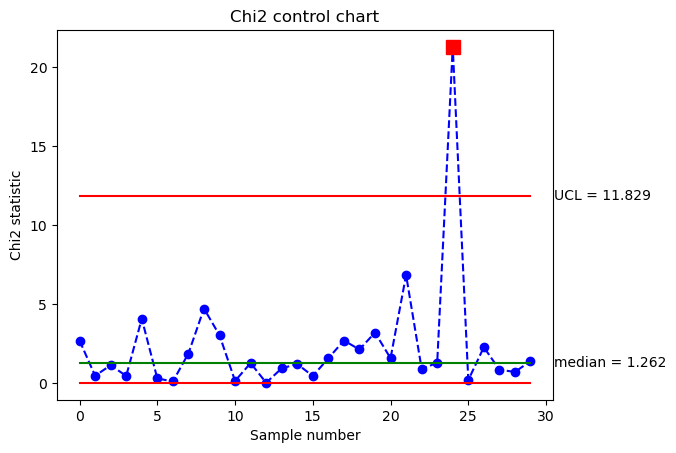

In [6]:
# Plot the Chi2 control chart
plt.title('Chi2 control chart')
plt.plot(data_CC['Chi2'], color='b', linestyle='--', marker='o')
plt.plot(data_CC['Chi2_UCL'], color='r')
plt.plot(data_CC['Chi2_CL'], color='g')
plt.plot(data_CC['Chi2_LCL'], color='r')
plt.ylabel('Chi2 statistic')
plt.xlabel('Sample number')
# add the values of the control limits on the right side of the plot
plt.text(len(data_CC)+.5, data_CC['Chi2_UCL'].iloc[0], 'UCL = {:.3f}'.format(data_CC['Chi2_UCL'].iloc[0]), verticalalignment='center')
plt.text(len(data_CC)+.5, data_CC['Chi2_CL'].iloc[0], 'median = {:.3f}'.format(data_CC['Chi2_CL'].iloc[0]), verticalalignment='center')
# highlight the points that violate the alarm rules
plt.plot(data_CC['Chi2_TEST'], linestyle='none', marker='s', color='r', markersize=10)
plt.show()

> As we can see the sample at position 24 (therefore sample 25) is OOC

> ## Exercise 4 (continued)
> If we don’t know the true values of the parameters, we should design the 
chart (Phase I) with $n=1$. One way to estimate **S** (the best when $n = 1$) is:

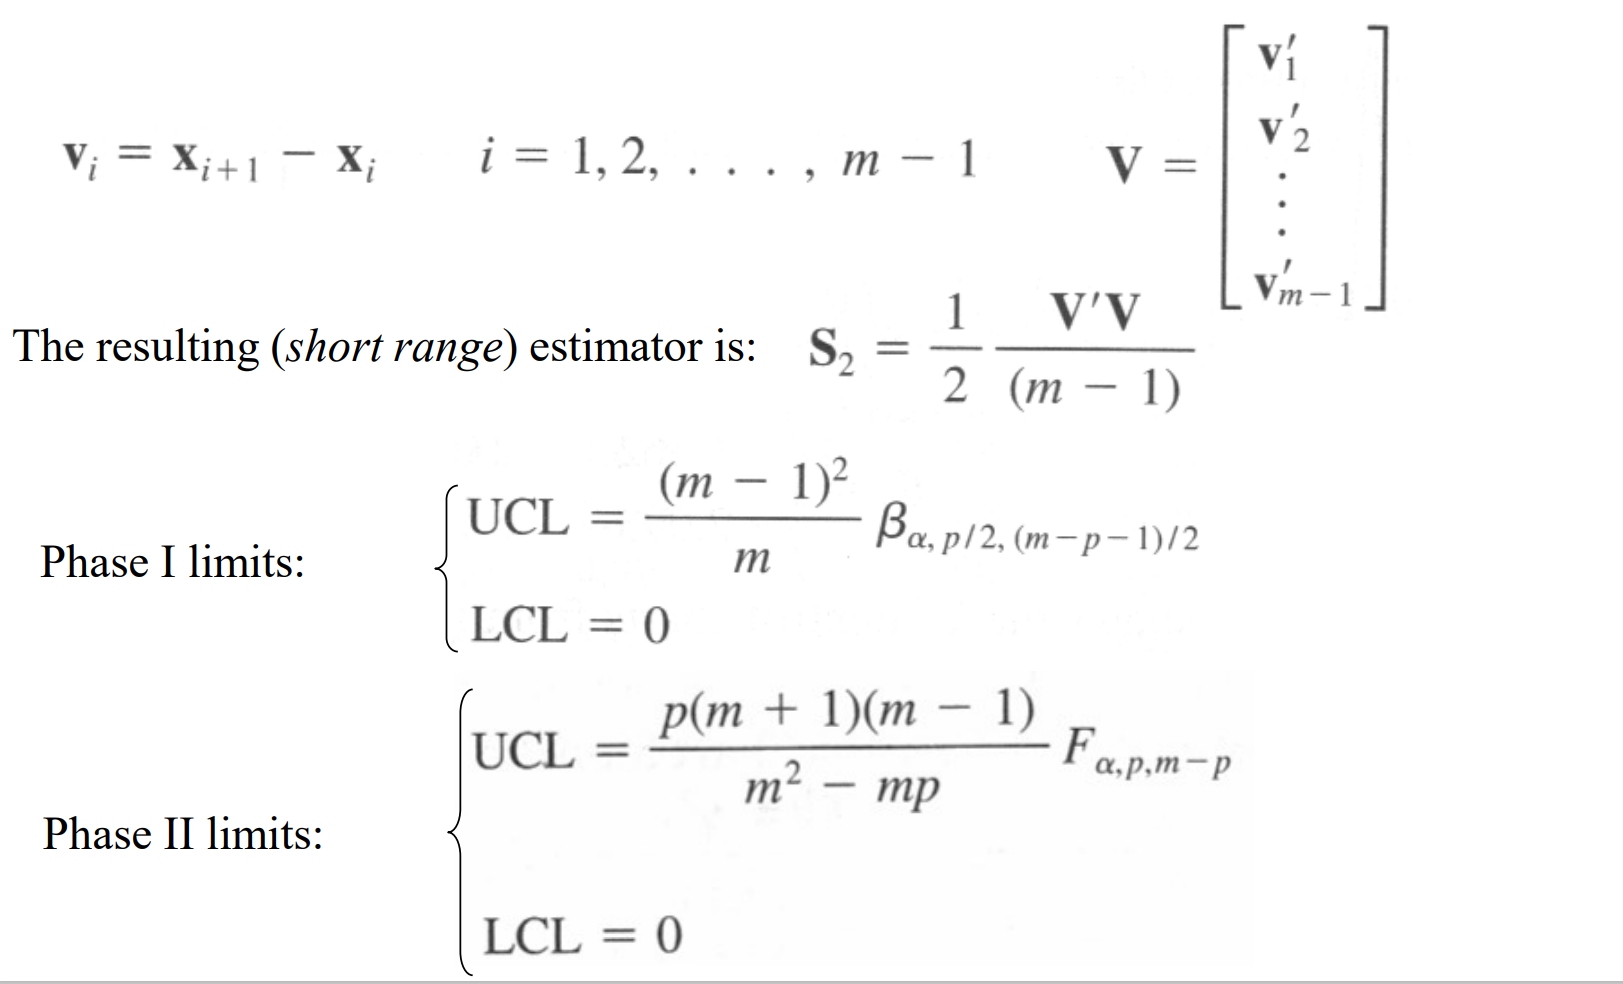

In [7]:
# Create the V matrix
V = data.diff().dropna()

# Calculate the short range estimator S2
S2 = 1/2 * V.transpose().dot(V) / (m-1)

# Display the short range estimator
print("The short range estimator is: \n", S2)

The short range estimator is: 
           x1        x2
x1  1.232222  2.001583
x2  2.001583  4.860412


> With the estimator $\mathbf{S_2}$ we can now compute the Hotelling's $T^2$ statistic of the samples

In [8]:
# Calculate the Xbar from the data
Xbar = data.mean()

S2_inv = np.linalg.inv(S2)

# Calculate the Hotelling T2 statistic
data_CC['T2'] = np.nan
for i in range(m):
    data_CC['T2'].iloc[i] = n * (data.iloc[i] - Xbar).transpose().dot(S2_inv).dot(data.iloc[i] - Xbar)

# Now we can add the UCL, CL and LCL to the dataframe
data_CC['T2_UCL'] = ((m-1)**2)/m*stats.beta.ppf(1 - alpha, p/2, (m-p-1)/2)
data_CC['T2_CL'] = data_CC['T2'].median()
data_CC['T2_LCL'] = 0

# Add one column to test if the sample is out of control
data_CC['T2_TEST'] = np.where((data_CC['T2'] > data_CC['T2_UCL']), data_CC['T2'], np.nan)

# Inspect the dataset
data_CC.head()


c:\Users\matte\anaconda3\envs\qda\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,x1,x2,Chi2,Chi2_UCL,Chi2_CL,Chi2_LCL,Chi2_TEST,T2,T2_UCL,T2_CL,T2_LCL,T2_TEST
0,11.09,20.28,2.676500,11.829007,1.262424,0,NaN,1.731331,9.944715,1.124725,0,NaN
1,9.33,19.01,0.453569,11.829007,1.262424,0,NaN,0.596517,9.944715,1.124725,0,NaN
2,10.95,20.96,1.120278,11.829007,1.262424,0,NaN,0.613175,9.944715,1.124725,0,NaN
3,10.53,21.33,0.442236,11.829007,1.262424,0,NaN,0.420886,9.944715,1.124725,0,NaN
4,11.95,22.51,4.060903,11.829007,1.262424,0,NaN,2.776166,9.944715,1.124725,0,NaN


> Let's plot the $T^2$ CC

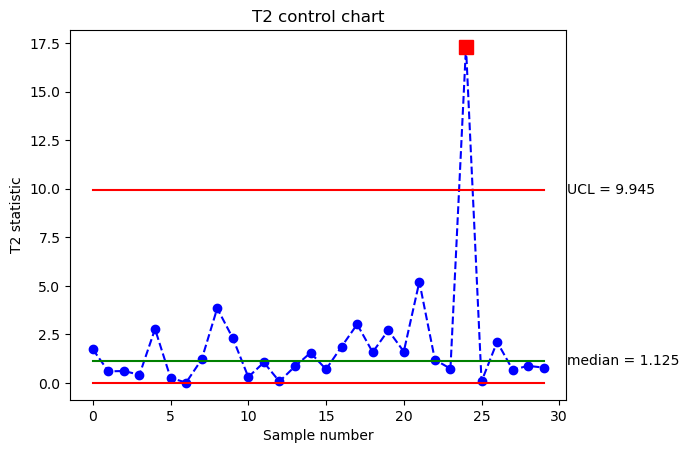

In [9]:
# Plot the T2 control chart
plt.title('T2 control chart')
plt.plot(data_CC['T2'], color='b', linestyle='--', marker='o')
plt.plot(data_CC['T2_UCL'], color='r')
plt.plot(data_CC['T2_CL'], color='g')
plt.plot(data_CC['T2_LCL'], color='r')
plt.ylabel('T2 statistic')
plt.xlabel('Sample number')
# add the values of the control limits on the right side of the plot
plt.text(len(data_CC)+.5, data_CC['T2_UCL'].iloc[0], 'UCL = {:.3f}'.format(data_CC['T2_UCL'].iloc[0]), verticalalignment='center')
plt.text(len(data_CC)+.5, data_CC['T2_CL'].iloc[0], 'median = {:.3f}'.format(data_CC['T2_CL'].iloc[0]), verticalalignment='center')
# highlight the points that violate the alarm rules
plt.plot(data_CC['T2_TEST'], linestyle='none', marker='s', color='r', markersize=10)
plt.show()